In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as torchv
import numpy as np
import mymodels
import mycoco_emb as mycoco
import torchvision.transforms as transforms
import torch.utils.data as data
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
import os
import pdb
from models.model_embedding_128 import Embdding_128 as model_emb


os.environ["CUDA_VISIBLE_DEVICES"] = "3,4"

import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [2]:
BATCH_SIZE = 64
cuda = torch.cuda.is_available()
IMAGE_SIZE = 224

In [3]:
def create_dataset(name='train', batch_size=32):
    dataDir='/scratch/cluster-share/linzhe/cocoDataset/'
    dataType='%s2017'%name
    annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
    root = '%s%s'%(dataDir, dataType)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
    trans = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                transforms.ToTensor()])
    target_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                           transforms.ToTensor()
                                           ]) # normalize to be in [-1, 1]
    coco = mycoco.CocoDetection(root, annFile, transform=trans, target_transform=target_transform, categories=['apple', 'orange', 'donut'])
    cocoloader = data.DataLoader(coco, batch_size, num_workers=4, shuffle=True)
    
    return cocoloader, coco

In [4]:
cocoloader, cocoDataset = create_dataset(name='train', batch_size=BATCH_SIZE)
data_loader = cocoloader

loading annotations into memory...
Done (t=21.59s)
creating index...
index created!


apple,apple,donut,donut,apple,donut,orange,donut,orange,apple,donut,apple,donut,donut,donut,apple,orange,orange,orange,donut,orange,apple,donut,donut,apple,apple,orange,donut,apple,orange,apple,apple,donut,apple,orange,orange,orange,donut,donut,apple,donut,apple,apple,apple,orange,orange,donut,orange,apple,donut,orange,apple,orange,orange,orange,orange,orange,donut,donut,orange,donut,donut,donut,orange,

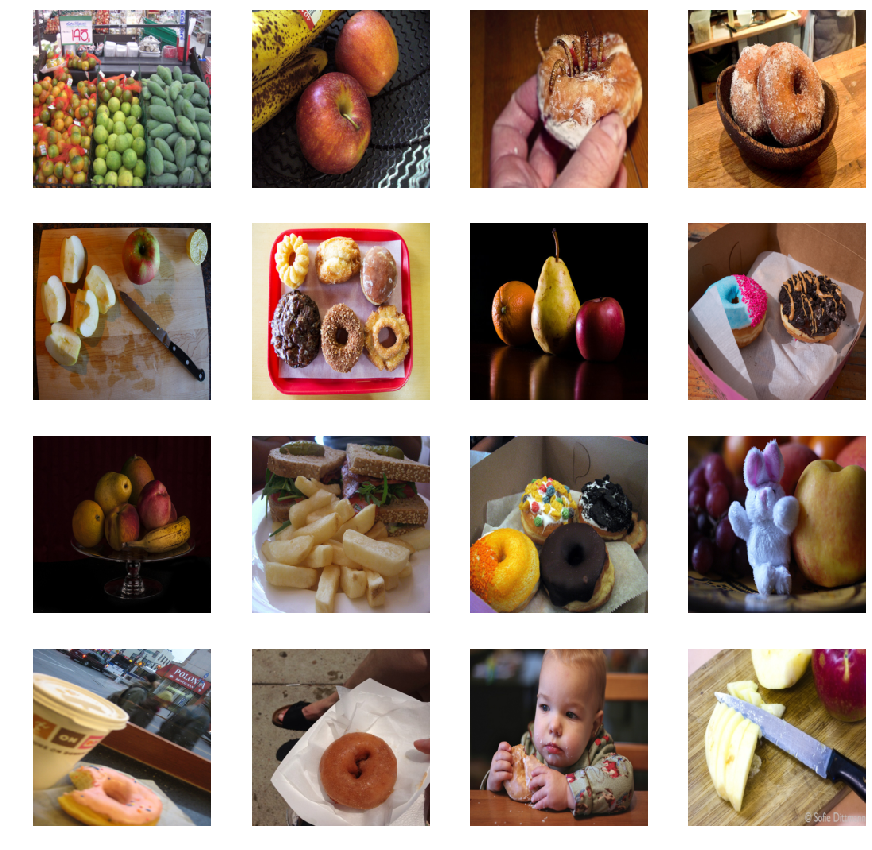

In [5]:

f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
i = 0
j = 0
for im, mask, nms in cocoloader:
#     print(im.shape)
    for image in im:
#         print(image.numpy().T.shape)
        axarr[i, j].imshow(np.swapaxes(np.swapaxes(image.numpy(),0,1),1,2))
        axarr[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break
for nm in nms:
    print(nm + ',', end = '')
    

In [6]:
def deTanh(x):
    return x.add(1).mul(0.5)
def Tanhize(x):
    return x.mul(2).add(-1)

In [14]:
model = model_emb(IMAGE_SIZE)
if cuda:
    model.cuda()
num_epochs = 10000
d2 =  {str(k)[7:]:v for k,v in torch.load('weights/last_weight.pkl').items()}
model.load_state_dict(d2)
model = nn.DataParallel(model)
model.batch_size = BATCH_SIZE
learning_rate = 1e-3
model.eval()

imgs_emb = torch.zeros((512, 3, 224, 224)).cuda()
emb_vec = torch.zeros((512, 128)).cuda()
class_emb = torch.zeros((512, 3)).cuda()


for i, (images, masks, nms) in enumerate(cocoloader):
    images = np.multiply(images,masks)
    if cuda:
        x = Tanhize(Variable(images).cuda())
        x2 = Variable(images).cuda()
    else:
        x = Tanhize(Variable(images))

    z, x_hat = model(x)

#     print(z.shape)
#     print(x.shape)
#     break
    start = i * BATCH_SIZE
    end = (i + 1) * BATCH_SIZE
    print(end)
    imgs_emb[start : end] = x2
    emb_vec[start : end] = z
    
    for j, nm in enumerate(nms):
        if nm == 'apple':
            class_emb[start + j] = torch.tensor([1, 0, 0])
        if nm == 'orange':
            class_emb[start + j] = torch.tensor([0, 1, 0])
        if nm == 'donut':
            class_emb[start + j] = torch.tensor([0, 0, 1])
#     nms_emb[start : end] = nms
    
    if i == 7:
        break
torch.save(imgs_emb, 'emb_info/imgs.pt')
torch.save(emb_vec, 'emb_info/embeddings.pt')
torch.save(class_emb, 'emb_info/class_embeddings.pt')
print(nms[63])
print(class_emb[511])
    

RuntimeError: CUDA error: out of memory (malloc at /opt/conda/conda-bld/pytorch_1549628766161/work/aten/src/THC/THCCachingAllocator.cpp:205)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x45 (0x7fcdddca2cf5 in /nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x122853f (0x7fcde1f7353f in /nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torch/lib/libcaffe2_gpu.so)
frame #2: <unknown function> + 0x1228d4a (0x7fcde1f73d4a in /nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torch/lib/libcaffe2_gpu.so)
frame #3: at::native::empty_cuda(c10::ArrayRef<long>, at::TensorOptions const&) + 0x2d6 (0x7fcde3360a36 in /nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torch/lib/libcaffe2_gpu.so)
frame #4: at::CUDAFloatType::empty(c10::ArrayRef<long>, at::TensorOptions const&) const + 0x161 (0x7fcde1e91b21 in /nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torch/lib/libcaffe2_gpu.so)
frame #5: torch::autograd::VariableType::empty(c10::ArrayRef<long>, at::TensorOptions const&) const + 0x179 (0x7fcdd6e50209 in /nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torch/lib/libtorch.so.1)
frame #6: at::TypeDefault::copy(at::Tensor const&, bool, c10::optional<c10::Device>) const + 0x122 (0x7fcdde7a7532 in /nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torch/lib/libcaffe2.so)
frame #7: <unknown function> + 0x719737 (0x7fcdde5cd737 in /nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torch/lib/libcaffe2.so)
frame #8: at::native::to(at::Tensor const&, at::TensorOptions const&, bool, bool) + 0x295 (0x7fcdde5cf2e5 in /nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torch/lib/libcaffe2.so)
frame #9: at::TypeDefault::to(at::Tensor const&, at::TensorOptions const&, bool, bool) const + 0x17 (0x7fcdde76dce7 in /nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torch/lib/libcaffe2.so)
frame #10: torch::autograd::VariableType::to(at::Tensor const&, at::TensorOptions const&, bool, bool) const + 0x17a (0x7fcdd6df8bba in /nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torch/lib/libtorch.so.1)
frame #11: torch::cuda::scatter(at::Tensor const&, c10::ArrayRef<long>, c10::optional<std::vector<long, std::allocator<long> > > const&, long, c10::optional<std::vector<c10::optional<at::cuda::CUDAStream>, std::allocator<c10::optional<at::cuda::CUDAStream> > > > const&) + 0x491 (0x7fcdff29ff71 in /nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torch/lib/libtorch_python.so)
frame #12: <unknown function> + 0x4f0c51 (0x7fcdff2a5c51 in /nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torch/lib/libtorch_python.so)
frame #13: <unknown function> + 0x111826 (0x7fcdfeec6826 in /nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torch/lib/libtorch_python.so)
frame #14: _PyCFunction_FastCallDict + 0x154 (0x56294f948744 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #15: <unknown function> + 0x19842c (0x56294f9cf42c in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #16: _PyEval_EvalFrameDefault + 0x30a (0x56294f9f438a in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #17: <unknown function> + 0x1918e4 (0x56294f9c88e4 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #18: <unknown function> + 0x192771 (0x56294f9c9771 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #19: <unknown function> + 0x198505 (0x56294f9cf505 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #20: _PyEval_EvalFrameDefault + 0x30a (0x56294f9f438a in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #21: PyEval_EvalCodeEx + 0x329 (0x56294f9ca289 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #22: <unknown function> + 0x194094 (0x56294f9cb094 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #23: PyObject_Call + 0x3e (0x56294f94854e in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #24: THPFunction_apply(_object*, _object*) + 0x579 (0x7fcdff0c11d9 in /nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torch/lib/libtorch_python.so)
frame #25: _PyCFunction_FastCallDict + 0x91 (0x56294f948681 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #26: <unknown function> + 0x19842c (0x56294f9cf42c in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #27: _PyEval_EvalFrameDefault + 0x30a (0x56294f9f438a in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #28: <unknown function> + 0x191bfe (0x56294f9c8bfe in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #29: _PyFunction_FastCallDict + 0x1bc (0x56294f9c9c4c in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #30: _PyObject_FastCallDict + 0x26f (0x56294f948b0f in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #31: <unknown function> + 0x12c272 (0x56294f963272 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #32: PyIter_Next + 0xe (0x56294f98ae3e in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #33: PySequence_Tuple + 0xf9 (0x56294f98fc99 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #34: _PyEval_EvalFrameDefault + 0x53c0 (0x56294f9f9440 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #35: <unknown function> + 0x191bfe (0x56294f9c8bfe in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #36: <unknown function> + 0x192771 (0x56294f9c9771 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #37: <unknown function> + 0x198505 (0x56294f9cf505 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #38: _PyEval_EvalFrameDefault + 0x30a (0x56294f9f438a in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #39: <unknown function> + 0x191bfe (0x56294f9c8bfe in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #40: <unknown function> + 0x192771 (0x56294f9c9771 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #41: <unknown function> + 0x198505 (0x56294f9cf505 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #42: _PyEval_EvalFrameDefault + 0x30a (0x56294f9f438a in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #43: <unknown function> + 0x1918e4 (0x56294f9c88e4 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #44: <unknown function> + 0x192771 (0x56294f9c9771 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #45: <unknown function> + 0x198505 (0x56294f9cf505 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #46: _PyEval_EvalFrameDefault + 0x10c7 (0x56294f9f5147 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #47: <unknown function> + 0x19253b (0x56294f9c953b in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #48: <unknown function> + 0x198505 (0x56294f9cf505 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #49: _PyEval_EvalFrameDefault + 0x30a (0x56294f9f438a in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #50: <unknown function> + 0x1918e4 (0x56294f9c88e4 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #51: _PyFunction_FastCallDict + 0x3da (0x56294f9c9e6a in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #52: _PyObject_FastCallDict + 0x26f (0x56294f948b0f in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #53: _PyObject_Call_Prepend + 0x63 (0x56294f94d6a3 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #54: PyObject_Call + 0x3e (0x56294f94854e in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #55: _PyEval_EvalFrameDefault + 0x19ec (0x56294f9f5a6c in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #56: <unknown function> + 0x1918e4 (0x56294f9c88e4 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #57: _PyFunction_FastCallDict + 0x1bc (0x56294f9c9c4c in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #58: _PyObject_FastCallDict + 0x26f (0x56294f948b0f in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #59: _PyObject_Call_Prepend + 0x63 (0x56294f94d6a3 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #60: PyObject_Call + 0x3e (0x56294f94854e in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #61: <unknown function> + 0x16ba91 (0x56294f9a2a91 in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #62: _PyObject_FastCallDict + 0x8b (0x56294f94892b in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)
frame #63: <unknown function> + 0x19857e (0x56294f9cf57e in /nfs/stak/users/linzhe/miniconda3/envs/general/bin/python)


In [15]:
def reshapeTensor(images, new_size):
    import torch
    from torchvision import transforms
    p = transforms.Compose([transforms.Scale((48,48))])
    from PIL import Image
    new_imgs = []
    for img in imgs:
        x = torch.tensor(img)
        x = transforms.ToPILImage()(x)
        x = transforms.functional.resize(x,new_size)
        new_imgs.append(transforms.ToTensor()(x).numpy())

    print(np.array(new_imgs).shape)
    return np.array(new_imgs)

In [32]:
imgs = torch.load( 'emb_info/imgs.pt').data.cpu().numpy()
imgs = deTanh(torch.tensor(imgs)).data.numpy() # reshape to -1 to 1 
embeddings = torch.load('emb_info/embeddings.pt').data.cpu().numpy()
_class = torch.load( 'emb_info/class_embeddings.pt').data.cpu().numpy()

In [33]:
print(imgs.shape, embeddings.shape,_class.shape)
print(np.max(imgs), np.min(imgs))

(512, 3, 224, 224) (512, 128) (512, 3)
1.0 0.0


In [34]:
imgs = reshapeTensor(imgs, new_size = 64)  # reshape to 64 for all images
embeddings = torch.nn.functional.pad(torch.tensor(embeddings),(0,896)).numpy()  # reshape embedding to 1024
imgs = Tanhize(torch.tensor(imgs)).data.numpy() # reshape to -1 to 1 

(512, 3, 64, 64)


In [35]:
print(imgs.shape, embeddings.shape,_class.shape)
print(np.max(imgs), np.min(imgs))

(512, 3, 64, 64) (512, 1024) (512, 3)
1.0 -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 64, 64)


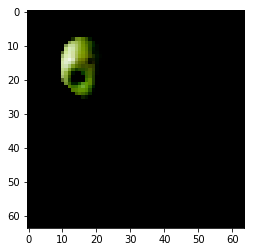

In [36]:
print(imgs[0].shape)
plt.imshow(np.swapaxes(np.swapaxes(imgs[0],0,1),1,2))

In [37]:
import os
from os.path import join, isfile
import numpy as np
import h5py
from glob import glob
# from torch.utils.serialization import load_lua
from PIL import Image
import yaml
import io
import pdb

In [38]:
# with open('config.yaml', 'r') as f:
# 	config = yaml.load(f)
datasetDir = '/scratch/cluster-share/linzhe/text2image/flowersV8.hdf5'

f = h5py.File(datasetDir, 'w')
train = f.create_group('train')
valid = f.create_group('valid')
test = f.create_group('test')

# for _class in sorted(os.listdir(embedding_path)):
# 	split = ''
# 	if _class in train_classes:
# 		split = train
# 	elif _class in val_classes:
# 		split = valid
# 	elif _class in test_classes:
# 		split = test

In [39]:

# img = []

dt = h5py.special_dtype(vlen=str)
split = train

for c, e in enumerate(embeddings):
    ex = split.create_group('colors_'+str(c))
    ex.create_dataset('name', data="colors")
    ex.create_dataset('img', data=np.array(imgs[c]))
    ex.create_dataset('embeddings', data=e)
    ex.create_dataset('class', data="dummy_class")
    ex.create_dataset('txt', data=str("dummy_text"), dtype=dt)
# f.close()


In [40]:
# img = []

dt = h5py.special_dtype(vlen=str)
split = test

for c, e in enumerate(embeddings):
    ex = split.create_group('colors_'+str(c))
    ex.create_dataset('name', data="colors")
    ex.create_dataset('img', data=np.array(imgs[c]))
    ex.create_dataset('embeddings', data=e)
    ex.create_dataset('class', data="dummy_class")
    ex.create_dataset('txt', data=str("dummy_text"), dtype=dt)
# f.close()

In [41]:
# img = []

dt = h5py.special_dtype(vlen=str)
split = valid

for c, e in enumerate(embeddings):
    ex = split.create_group('colors_'+str(c))
    ex.create_dataset('name', data="colors")
    ex.create_dataset('img', data=np.array(imgs[c]))
    ex.create_dataset('embeddings', data=e)
    ex.create_dataset('class', data="dummy_class")
    ex.create_dataset('txt', data=str("dummy_text"), dtype=dt)
# f.close()

In [42]:
f.close()